# Effects of Inertia Parameters on Absorption - Case Study through Simple Mean-field Team

In [1]:
import itertools
import numpy as np
import networkx as nx
from tqdm import tqdm

from sympy import *
from sympy.interactive import printing
from IPython.display import Math, display

import matplotlib.pyplot as plt

from br_graph_analysis import learn_br_graph, transition_matrix_from_br_graph

## Mean-field team problem

We study a "mean-field" team problem with only a single state (so no state transitions), and 2 actions for each of the $N$ agents. That is, $\mathcal{X} = \{0\}$, $\mathcal{U}=\{0,1\}$. The reward function is simply $r(x, \mathbf{u}) = -\bar{u} + 2 \cdot 1_{\{\bar{u}=1\}}$, where $\bar{u}$ is the mean action: $\bar{u} = \frac{1}{N}\sum_{i=1}^N{u^i}$. So, the team penalizes taking the action $1$, unless $1$ is the only action being taken, in which case the reward is high. So, for all $N$, there are two equilibria. The joint policy of all agents taking the action $1$ is the team-optimal equilibrium, and the joint policy of all agents taking the action $0$ is a suboptimal equilibrium.

In [2]:
# MEAN-FIELD PARAMETERS
n_states = 1 # number of states
n_actions_const = 2 # all agents have the same action spaces

def get_initial_state():
    # initial state distribution
    return np.random.choice(range(n_states)) # uniform over states for now 

init_state = 0

def transition_state(x, us):
    '''returns next state given current state and action'''
    
    # there's only one state
    return x

def mf_reward(x, u_i, mean_u):
    return -mean_u + 2*(mean_u == 1) # TEMP**

def gen_reward_i(i):
    def reward_i(state, actions):
        ui = actions[i]
        mean_u = np.average(actions)
        return mf_reward(state, ui, mean_u)
    
    return reward_i

beta_const = 0.9 # discount rate; constant across agents

## $N=2$

### Learn BR Graph

First, we learn the best-reply graph for $N=2$.

In [3]:
n_agents = 2

# GAME PARAMS (adjusted for n-agents)
n_Us = [n_actions_const] * n_agents # number of actions per agent (both agents have two actions)
reward_funcs = [gen_reward_i(i) for i in range(n_agents)]
betas = [beta_const]*n_agents # discount factor

# LEARNING PARAMETERS
T = 10000 # length of exploration phase
experimentation_probs = [0.01]*n_agents # probability of experimentation at each action (\rho)
alpha_func = lambda n: 1/n
deltas = [1e-6]*n_agents # tolerance for suboptimality


# learn BR graph
br_graph2 = learn_br_graph(n_agents, n_states, n_Us, init_state, transition_state, reward_funcs, betas,
                  T, experimentation_probs, alpha_func, deltas)

100%|████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.37s/it]


We obtain the following graph.

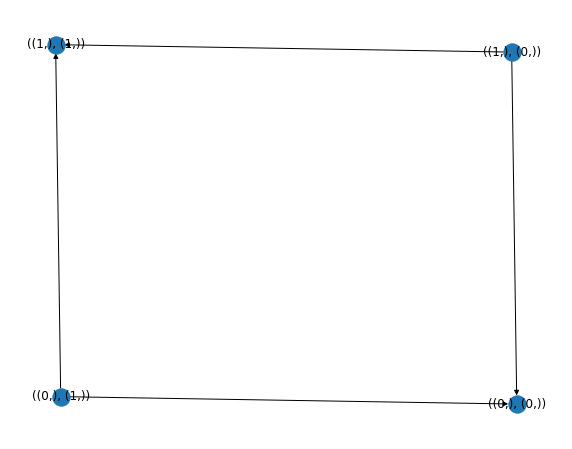

In [4]:
# draw BR graph (without self-loops)
br_graph_ = nx.DiGraph.copy(br_graph2)
br_graph_.remove_edges_from(nx.selfloop_edges(br_graph_))
fig, ax = plt.subplots(figsize=(10,8))
nx.draw_spectral(br_graph_, with_labels=True, ax=ax)

We confirm that the sinks of the graph are the equilibria we expect.

In [5]:
[node for node in br_graph_.nodes if br_graph_.out_degree(node) == 0]

[((0,), (0,)), ((1,), (1,))]

### Study effect of inertia on absorption probabilities

Now we look at the effect of different inertia values on the probability of convergin to the team optimal equilibrium.

In [6]:
agent_policy_spaces = [list(itertools.product(range(n_Us[i]), repeat=n_states)) for i in range(n_agents)]
joint_policy_space = list(itertools.product(*agent_policy_spaces))

In [7]:
# BR Process Inertia PARAMETERS

# constant inertia
const_inertia = 0.5
agent_inertias = [const_inertia]*n_agents

# # different inertias
# agent_inertias = [0.99, 0.001, 0.001]

Compute transition matrix.

In [8]:
P_, jps_dict = transition_matrix_from_br_graph(br_graph2, agent_inertias, joint_policy_space)
P_ = P_.astype(float)
P = Matrix(P_).applyfunc(nsimplify)
display(Math(f'P = {printing.default_latex(P)}')) # too big to display

<IPython.core.display.Math object>

In [9]:
P_inf_ = np.round(np.linalg.matrix_power(P_, 1000), 10)
P_inf = Matrix(P_inf_).applyfunc(nsimplify)
display(Math(f'P_\infty = {printing.default_latex(P_inf)}'))

<IPython.core.display.Math object>

In [10]:
uniform_dist = [1/len(joint_policy_space)]*len(joint_policy_space)
final_dist = Matrix(uniform_dist @ P_inf_).T.applyfunc(nsimplify)
final_dist.evalf(3)

Matrix([[0.5, 0, 0, 0.5]])

Summary: For $N=2$, absorption probabilities are equal regardless of inertia if the initial state distribution is uniform (if not uniform, inertia does have an effect).

### Symbolic Analysis

In [11]:
agent_inertias = symbols(f'lambda_0:{n_agents}')

P_, jps_dict = transition_matrix_from_br_graph(br_graph2, agent_inertias, joint_policy_space)

P = Matrix(P_)
display(Math(f'P = {printing.default_latex(P)}'))

<IPython.core.display.Math object>

In [12]:
abs_states = [0, len(joint_policy_space)-1]
trans_states = [i for i in range(len(joint_policy_space)) if i not in abs_states]

Q_ = P_[trans_states][:, trans_states]
Q = Matrix(Q_).applyfunc(nsimplify)
display(Math(f'Q = {printing.default_latex(Q)}'))

R_ = P_[trans_states][:, abs_states]
R = Matrix(R_).applyfunc(nsimplify)
display(Math(f'R = {printing.default_latex(R)}'))

reorder = trans_states + abs_states
P_ro_ = P_[reorder][:, reorder]
P_ro = Matrix(P_ro_).applyfunc(nsimplify)
can_P = '\\begin{bmatrix} Q & R\\\\ \\mathbf{0} & I_r \\end{bmatrix}'
display(Math(f'{can_P} = {printing.default_latex(P_ro)}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [13]:
Id = Matrix(np.eye(Q.shape[0])).applyfunc(nsimplify)
N = simplify((Id - Q).inv())
display(Math(f'N = {printing.default_latex(N)}'))

<IPython.core.display.Math object>

In [14]:
B = simplify(N@R)
display(Math(f'B = {printing.default_latex(B)}'))

<IPython.core.display.Math object>

In [15]:
uniform_dist = Matrix([1/B.shape[0]]*B.shape[0]).T
final_dist = simplify(Matrix(uniform_dist @ B))
final_dist

Matrix([[0.5, 0.5]])

In [16]:
left_side = np.zeros((len(abs_states) + len(trans_states), len(trans_states)))
right_side = np.vstack((B, np.eye(len(abs_states))))
P_inf_can = Matrix(np.hstack((left_side, right_side))).applyfunc(nsimplify)
display(Math(f'P_\infty = {printing.default_latex(P_inf_can)}')) # canonical form of P_inf

<IPython.core.display.Math object>

In [17]:
uniform_dist = Matrix([1/len(joint_policy_space)]*len(joint_policy_space)).T
final_dist = simplify(Matrix(uniform_dist @ P_inf_can))
final_dist

Matrix([[0, 0, 0.5, 0.5]])

In [18]:
print(printing.default_latex(final_dist))

\left[\begin{matrix}0 & 0 & 0.5 & 0.5\end{matrix}\right]


Thus, via symbolic computation, we confirm that the final distribution of states is evenly split, regardless of inertia parameters if the initial distribution is uniform

## $N=3$

### Learn BR Graph

Here, we learn the best-reply graph for $N=3$.

In [19]:
n_agents = 3

# GAME PARAMS (adjusted for n-agents)
n_Us = [n_actions_const] * n_agents # number of actions per agent (both agents have two actions)
reward_funcs = [gen_reward_i(i) for i in range(n_agents)]
betas = [beta_const]*n_agents # discount factor

# LEARNING PARAMETERS
T = 10000 # length of exploration phase
experimentation_probs = [0.01]*n_agents # probability of experimentation at each action (\rho)
alpha_func = lambda n: 1/n
deltas = [1e-6]*n_agents # tolerance for suboptimality

# learn BR graph
br_graph3 = learn_br_graph(n_agents, n_states, n_Us, init_state, transition_state, reward_funcs, betas,
                  T, experimentation_probs, alpha_func, deltas)

100%|████████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.03s/it]


We obtain the following graph. (it has a nice lattice structure).

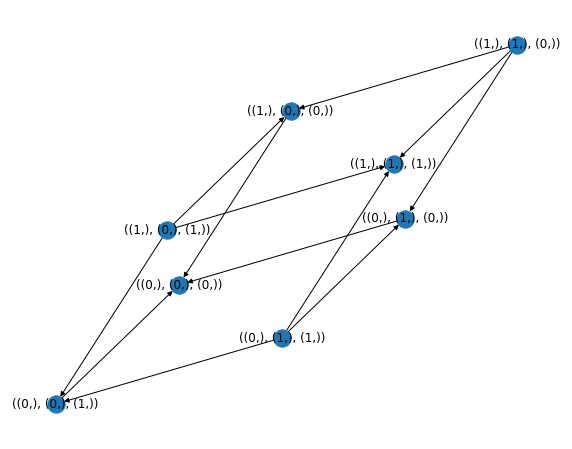

In [20]:
# draw BR graph (without self-loops)
br_graph_ = nx.DiGraph.copy(br_graph3)
br_graph_.remove_edges_from(nx.selfloop_edges(br_graph_))
fig, ax = plt.subplots(figsize=(10,8))
nx.draw_spectral(br_graph_, with_labels=True, ax=ax)

For $N=3$, the sinks of the BR graph are the equilibria we expect.

In [21]:
[node for node in br_graph_.nodes if br_graph_.out_degree(node) == 0] # absorbing states

[((0,), (0,), (0,)), ((1,), (1,), (1,))]

### Study effect of inertia on absorption probabilities

Now we look at the effect of different inertia values on the probability of convergin to the team optimal equilibrium.

In [22]:
agent_policy_spaces = [list(itertools.product(range(n_Us[i]), repeat=n_states)) for i in range(n_agents)]
joint_policy_space = list(itertools.product(*agent_policy_spaces))

In [23]:
# BR Process Inertia PARAMETERS

# constant inertia
const_inertia = 0.99
agent_inertias = [const_inertia]*n_agents

Compute transition matrix.

In [24]:
P_, jps_dict = transition_matrix_from_br_graph(br_graph3, agent_inertias, joint_policy_space)
P_ = P_.astype(float)
P = Matrix(P_).applyfunc(nsimplify)
display(Math(f'P = {printing.default_latex(P)}')) # too big to display

<IPython.core.display.Math object>

In [25]:
P_inf_ = np.round(np.linalg.matrix_power(P_, 100000), 10)
P_inf = Matrix(P_inf_).applyfunc(nsimplify)
display(Math(f'P_\infty = {printing.default_latex(P_inf)}'))

<IPython.core.display.Math object>

With a constant inertia of $0.5$, this gives the following distribution over final states. (the suboptimal equilibrium is favored $2:1$)

In [26]:
uniform_dist = [1/len(joint_policy_space)]*len(joint_policy_space)
final_dist = Matrix(uniform_dist @ P_inf_).T.applyfunc(nsimplify)
final_dist.evalf(3)

Matrix([[0.75, 0, 0, 0, 0, 0, 0, 0.25]])

However, unlike $N=2$, for $N=3$ different distributions are achievable for different values for inertia. 

Below, we compute the minimum and maximum achievable absorption probabilities by varying the inertia parameters.

In [27]:
import scipy.optimize

In [28]:
br_graph = br_graph3
eq_ind = -1 # index of team optimal equilibrium
epsilon = 1e-4

In [29]:
def get_abs_prob_n3(agent_inertias):
    P_, jps_dict = transition_matrix_from_br_graph(br_graph, agent_inertias, joint_policy_space)
    P_ = P_.astype(float)
    
    P_inf_ = np.linalg.matrix_power(P_, 100000)
    uniform_dist = [1/len(joint_policy_space)]*len(joint_policy_space)
    final_dist = uniform_dist @ P_inf_
    return final_dist[eq_ind]

In [30]:
# minimizing inertias (achieves prob of ~)
scipy.optimize.minimize(get_abs_prob_n3, bounds=[(epsilon,1-epsilon)]*3, x0=[0.5]*n_agents)

      fun: 0.12500000375037493
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.50022225e-05, 2.50022225e-05, 2.50022225e-05])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 20
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([0.0001, 0.0001, 0.0001])

In [31]:
# maximizing inertias (achieves of prob ~)
scipy.optimize.minimize(lambda x: -get_abs_prob_n3(x), bounds=[(epsilon,1-epsilon)]*3, x0=[0.5]*n_agents)

      fun: -0.2499958326388399
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.013894  , -0.01389399, -0.01389397])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 12
      nit: 2
     njev: 3
   status: 0
  success: True
        x: array([0.9999, 0.9999, 0.9999])

Thus, depending on the choice of inertias, either equilibrium could be much more likely than the other (approaching an 'interesting' limit).

Let $b_U^*(\lambda^1, ..., \lambda^N)$ be the probability of converging to the team optimal policy with the given inertias when the initial distribution is uniform. Then, for the mean-field problem above and $N=3$,

$\inf_\lambda{b_U^*(\mathbf{\lambda})} = \lim_{\lambda \to 0}{b_U^*(\lambda, \lambda, \lambda)} = 0.125$ and $\sup_\lambda{b_U^*(\mathbf{\lambda})} = \lim_{\lambda \to 1}{b_U^*(\lambda, \lambda, \lambda)} = 0.25 $

In [32]:
agent_inertias = symbols(f'lambda_0:{n_agents}')

P_, jps_dict = transition_matrix_from_br_graph(br_graph, agent_inertias, joint_policy_space)

P = Matrix(P_)
display(Math(f'P = {printing.default_latex(P)}'))

<IPython.core.display.Math object>

In [33]:
abs_states = [0, len(joint_policy_space)-1]
trans_states = [i for i in range(len(joint_policy_space)) if i not in abs_states]

Q_ = P_[trans_states][:, trans_states]
Q = Matrix(Q_).applyfunc(nsimplify)
display(Math(f'Q = {printing.default_latex(Q)}'))

R_ = P_[trans_states][:, abs_states]
R = Matrix(R_).applyfunc(nsimplify)
display(Math(f'R = {printing.default_latex(R)}'))

reorder = trans_states + abs_states
P_ro_ = P_[reorder][:, reorder]
P_ro = Matrix(P_ro_).applyfunc(nsimplify)
can_P = '\\begin{bmatrix} Q & R\\\\ \\mathbf{0} & I_r \\end{bmatrix}'
display(Math(f'{can_P} = {printing.default_latex(P_ro)}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Note: symbolically computing $N = (I - Q)^{-1}$ takes a really long time, even for a relatively small $6\times6$ matrix.

In [34]:
# compute fundamental matrix, N = (I-Q)^-1, using adjugate and determinant identity
Id = Matrix(np.eye(Q.shape[0])).applyfunc(nsimplify)
N = simplify((Id - Q).adjugate() / (Id - Q).det()) # VERY complicated matrix

In [35]:
# compute absorption prob matrix 
B = simplify(N*R)

In [36]:
B

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [37]:
# calculate P_inf in canonical form from B
left_side = np.zeros((len(abs_states) + len(trans_states), len(trans_states)))
right_side = np.vstack((B, np.eye(len(abs_states))))
P_inf_can = Matrix(np.hstack((left_side, right_side))).applyfunc(nsimplify)
display(Math(f'P_\infty = {printing.default_latex(P_inf_can)}')) # canonical form of P_inf

<IPython.core.display.Math object>

In [38]:
uniform_dist = Matrix([1/len(joint_policy_space)]*len(joint_policy_space)).applyfunc(nsimplify).T
final_dist = simplify(Matrix(uniform_dist @ P_inf_can))
final_dist

Matrix([[0, 0, 0, 0, 0, 0, (24*lambda_0**3*lambda_1**2*lambda_2**2 - 12*lambda_0**3*lambda_1**2*lambda_2 - 12*lambda_0**3*lambda_1*lambda_2**2 + 6*lambda_0**3*lambda_1*lambda_2 + 24*lambda_0**2*lambda_1**3*lambda_2**2 - 12*lambda_0**2*lambda_1**3*lambda_2 + 24*lambda_0**2*lambda_1**2*lambda_2**3 - 100*lambda_0**2*lambda_1**2*lambda_2**2 + 28*lambda_0**2*lambda_1**2*lambda_2 + 12*lambda_0**2*lambda_1**2 - 12*lambda_0**2*lambda_1*lambda_2**3 + 28*lambda_0**2*lambda_1*lambda_2**2 - 3*lambda_0**2*lambda_1*lambda_2 - 13*lambda_0**2*lambda_1 + 12*lambda_0**2*lambda_2**2 - 13*lambda_0**2*lambda_2 + 7*lambda_0**2 - 12*lambda_0*lambda_1**3*lambda_2**2 + 6*lambda_0*lambda_1**3*lambda_2 - 12*lambda_0*lambda_1**2*lambda_2**3 + 28*lambda_0*lambda_1**2*lambda_2**2 - 3*lambda_0*lambda_1**2*lambda_2 - 13*lambda_0*lambda_1**2 + 6*lambda_0*lambda_1*lambda_2**3 - 3*lambda_0*lambda_1*lambda_2**2 + 32*lambda_0*lambda_1*lambda_2 + lambda_0*lambda_1 - 13*lambda_0*lambda_2**2 + lambda_0*lambda_2 + 12*lambda_1

In [39]:
optimal_eq_prob = final_dist[-1]
optimal_eq_prob # expression for the probability of converging to team optimal policy (again, VERY complicated)

(8*lambda_0**3*lambda_1**2*lambda_2**2 - 4*lambda_0**3*lambda_1**2*lambda_2 - 4*lambda_0**3*lambda_1*lambda_2**2 + 2*lambda_0**3*lambda_1*lambda_2 + 8*lambda_0**2*lambda_1**3*lambda_2**2 - 4*lambda_0**2*lambda_1**3*lambda_2 + 8*lambda_0**2*lambda_1**2*lambda_2**3 - 28*lambda_0**2*lambda_1**2*lambda_2**2 + 4*lambda_0**2*lambda_1**2*lambda_2 + 4*lambda_0**2*lambda_1**2 - 4*lambda_0**2*lambda_1*lambda_2**3 + 4*lambda_0**2*lambda_1*lambda_2**2 + 3*lambda_0**2*lambda_1*lambda_2 - 3*lambda_0**2*lambda_1 + 4*lambda_0**2*lambda_2**2 - 3*lambda_0**2*lambda_2 + lambda_0**2 - 4*lambda_0*lambda_1**3*lambda_2**2 + 2*lambda_0*lambda_1**3*lambda_2 - 4*lambda_0*lambda_1**2*lambda_2**3 + 4*lambda_0*lambda_1**2*lambda_2**2 + 3*lambda_0*lambda_1**2*lambda_2 - 3*lambda_0*lambda_1**2 + 2*lambda_0*lambda_1*lambda_2**3 + 3*lambda_0*lambda_1*lambda_2**2 + 8*lambda_0*lambda_1*lambda_2 - lambda_0*lambda_1 - 3*lambda_0*lambda_2**2 - lambda_0*lambda_2 + 4*lambda_1**2*lambda_2**2 - 3*lambda_1**2*lambda_2 + lambda_

Testing the optimal values of inertia obtained through numerical methods on the analytical expression above. The results are the same!

In [40]:
optimal_eq_prob.subs(zip(agent_inertias, [0.0001, 0.0001, 0.0001]))

0.125000003750375

In [41]:
optimal_eq_prob.subs(zip(agent_inertias, [0.9999, 0.9999, 0.9999]))

0.249983547760850

In theory, the critical values of inertia obtained analytically (i.e.: through solving the system of equations corresponding to a gradient of 0) should be the same. However, the expression is so complicated that this takes too long to do.

In [42]:
system_eq = [optimal_eq_prob.diff(inertia_i) for inertia_i in agent_inertias]

In [43]:
# solve(system_eq) # takes too long! expression too complicated. 

In [44]:
prob_const_inertia = np.array([float(optimal_eq_prob.subs(zip(agent_inertias, [lamda]*n_agents)).evalf()) for lamda in np.linspace(0, 1, num=100)])

In [45]:
prob_const_inertia

array([0.125     , 0.12503864, 0.12515601, 0.12535411, 0.12563472,
       0.12599936, 0.12644928, 0.12698541, 0.12760841, 0.12831858,
       0.1291159 , 0.13      , 0.13097015, 0.13202527, 0.13316395,
       0.13438438, 0.13568447, 0.13706177, 0.13851351, 0.14003665,
       0.14162787, 0.14328358, 0.145     , 0.14677313, 0.14859882,
       0.15047277, 0.1523906 , 0.15434783, 0.15633994, 0.15836242,
       0.16041076, 0.1624805 , 0.16456723, 0.16666667, 0.16877461,
       0.17088702, 0.173     , 0.17510981, 0.1772129 , 0.17930591,
       0.18138568, 0.18344924, 0.18549383, 0.18751691, 0.18951613,
       0.19148936, 0.19343467, 0.19535032, 0.19723476, 0.19908665,
       0.20090479, 0.20268817, 0.20443596, 0.20614745, 0.20782209,
       0.20945946, 0.21105928, 0.21262136, 0.21414564, 0.21563216,
       0.21708103, 0.21849246, 0.21986673, 0.22120419, 0.22250524,
       0.22377034, 0.225     , 0.22619477, 0.22735523, 0.228482  ,
       0.22957572, 0.23063705, 0.23166667, 0.23266527, 0.23363